# Classificação - Satisfação de Passageiro em Linhas Aéreas

## Autores
- Felipe Bakowski Nantes de Souza  
- Vinicius Grecco Fonseca Mulato  
- Victor Soares


# 1.    Data set - Seleção

### FAZER

# 2. Data set - Explicação

Esse data set possui 25 colunas, 24 sendo potenciais features e 1 target (satisfação). Ela é uma variável categórica não ordenada e assume 2 valores: satisfeito ou neutro/insatisfeito. Ainda, a target está bem balanceada, estando divida em 43/57 %

Em relação as features, elas variam entre qualitativas e quantitativas, sendo majoritariamente qualitativas e com poucas linhas com valores faltando.

### Colunas

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mlp import mlp
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from utils import plot_distributions

# carregar os dois conjuntos
df_train = pd.read_csv("train.csv")
df_test  = pd.read_csv("test.csv")

# marcar a origem para poder separar depois
df_train["_source"] = "train"
df_test["_source"]  = "test"

# concatenar
df = pd.concat([df_train, df_test], ignore_index=True)

print("Shape combinado:", df.shape)
print(df["_source"].value_counts())

target = df['satisfaction']

df.columns

Shape combinado: (129880, 26)
_source
train    103904
test      25976
Name: count, dtype: int64


Index(['Unnamed: 0', 'id', 'Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Class', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction', '_source'],
      dtype='object')

### Target bem equilibrada

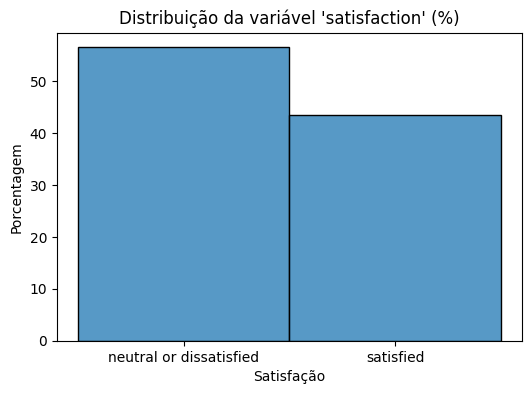

In [3]:
plt.figure(figsize=(6,4))
ax = sns.histplot(x=target, stat="percent", discrete=True)

plt.title("Distribuição da variável 'satisfaction' (%)")
plt.xlabel("Satisfação")
plt.ylabel("Porcentagem")
plt.show()

### Preenchendo valores vazios

In [4]:
print(df.columns[df.isnull().any()]) #observa-se colunas com valores faltando!

Index(['Arrival Delay in Minutes'], dtype='object')


### Arrival delay é numérica, utilizaremos a moda para preencher o valor, já que se arrival delay está como null, provavelmente foi 0 e esqueceram de colocar

In [5]:
df['Arrival Delay in Minutes'] = df['Arrival Delay in Minutes'].fillna(df['Arrival Delay in Minutes'].mode()[0])
print(df.columns[df.isnull().any()]) #roda mais uma vez para garantir

Index([], dtype='object')


### Visualização features

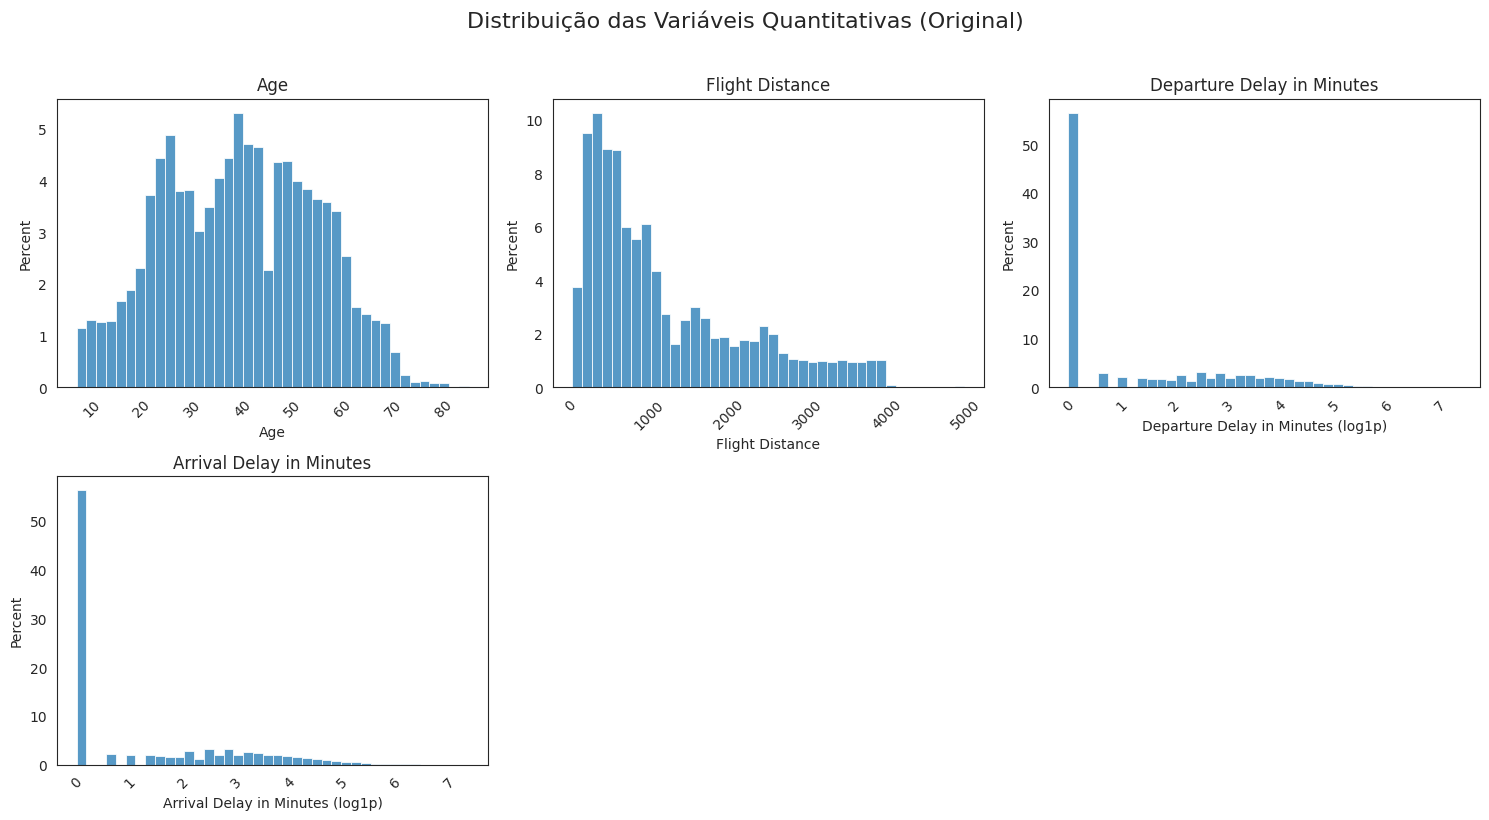

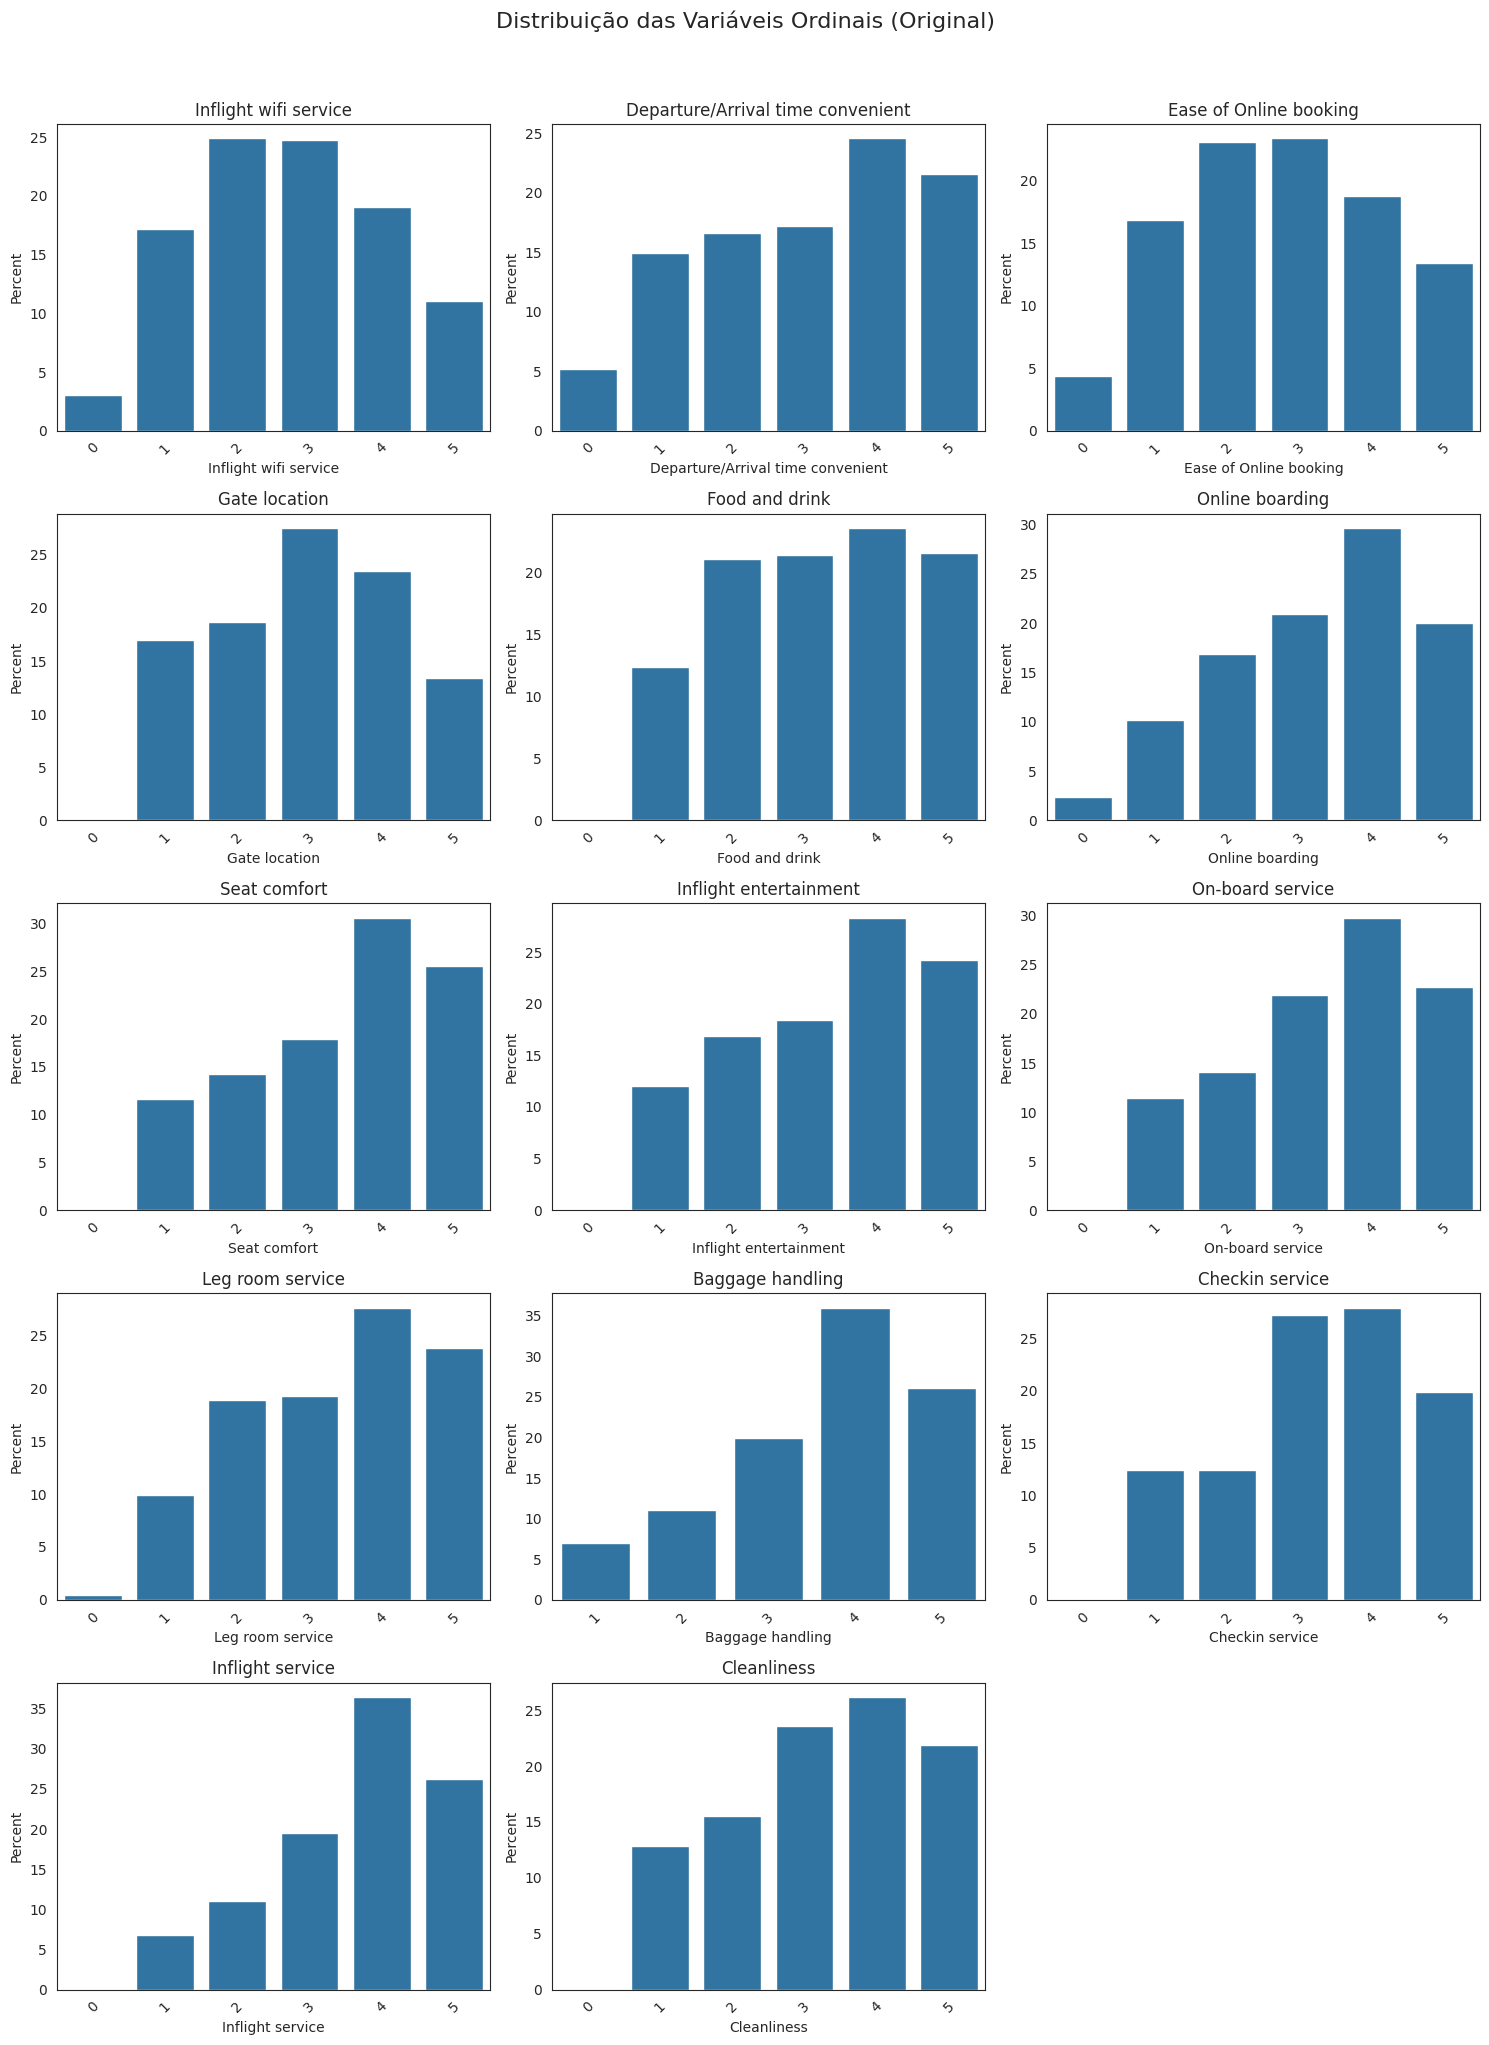

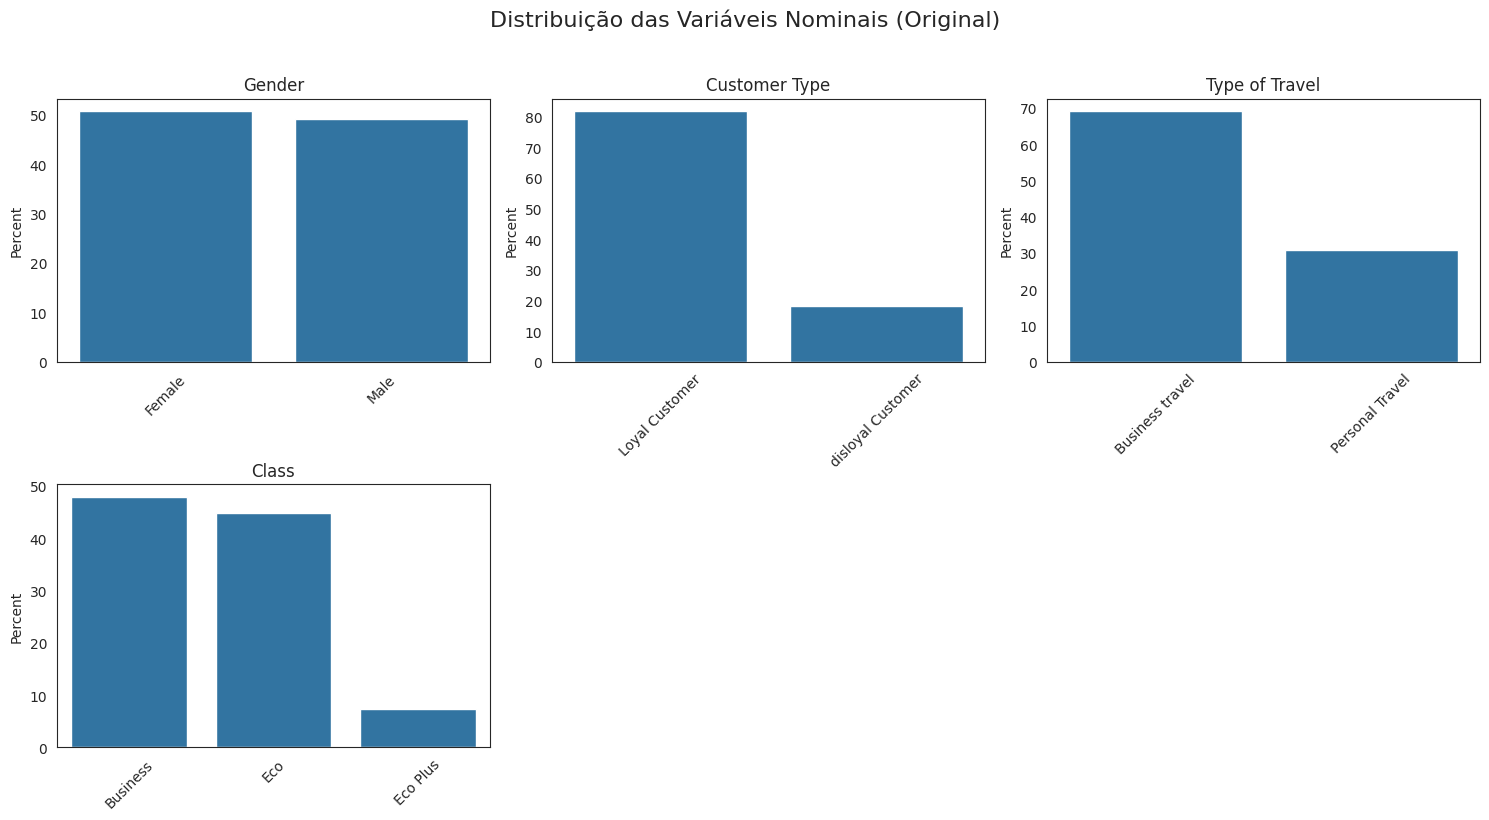

In [6]:
# definir colunas
quantitative_cols = ["Age", "Flight Distance", "Departure Delay in Minutes", "Arrival Delay in Minutes"]

ordinal_cols = [
    "Inflight wifi service",
    "Departure/Arrival time convenient",
    "Ease of Online booking",
    "Gate location",
    "Food and drink",
    "Online boarding",
    "Seat comfort",
    "Inflight entertainment",
    "On-board service",
    "Leg room service",
    "Baggage handling",
    "Checkin service",
    "Inflight service",
    "Cleanliness",
]

nominal_cols = ["Gender", "Customer Type", "Type of Travel", "Class"]
target_col = "satisfaction"

# -------- PLOT ORIGINAL --------
plot_distributions(df, quantitative_cols, ordinal_cols, nominal_cols, title_suffix="(Original)", force_ordinal_continuous=False)


Pelas distribuições apresentadas, as variáveis categóricas estão relativamente balanceadas em alguns aspectos, mas apresentam diferenças relevantes em outros. O gênero está equilibrado entre homens e mulheres. Já o tipo de cliente é bastante desbalanceado, com predominância de clientes leais. No tipo de viagem, há mais viagens de negócios do que pessoais. Em relação à classe, as categorias Business e Eco têm proporções próximas, enquanto Eco Plus aparece em bem menor quantidade. A variável de satisfação também é relativamente balanceada, com uma leve maioria de clientes insatisfeitos ou neutros.

Nas variáveis numéricas, observa-se diversidade: a idade segue uma distribuição concentrada entre 20 e 50 anos; a distância do voo é enviesada para valores menores; e os atrasos de partida e chegada apresentam forte concentração em atrasos curtos, com alguns outliers de longos atrasos. Já os serviços avaliativos (como wifi, comida, embarque, conforto de assento, limpeza, etc.) mostram distribuições variadas, mas tendem a concentrar respostas em notas intermediárias a altas, o que sugere certo viés positivo nas avaliações.

# 3. Limpeza de dados e normalização

Claro! Aqui vai uma explicação simples e direta sobre **por que normalizamos cada grupo de variáveis do jeito que fizemos**:

---

### 🔹 Z-Score (média 0, desvio 1)

Usamos em **Age** e nas variáveis **ordinais (avaliações de 1 a 5)**.

* **Por quê?**

  * O Z-score centraliza os dados na média e escala pela variabilidade.
  * Isso coloca todas essas variáveis em uma escala comparável (valores entre -2 e 2, geralmente).
  * É útil quando os dados são aproximadamente simétricos ou queremos destacar desvios em relação à média.

Exemplo: Idades diferentes são comparadas em termos de "quantos desvios padrão acima ou abaixo da média" estão.

---

### 🔹 Min-Max [-1, 1]

Usamos em **Flight Distance** e nos **delays (após log)**.

* **Por quê?**

  * O Min-Max traz os valores para um intervalo fixo, aqui entre -1 e 1.
  * Isso garante que nenhuma variável tenha escala muito maior que as outras.
  * É útil quando a distribuição não é centrada na média, mas queremos que o modelo “veja” tudo na mesma faixa.

---

### 🔹 Log + Min-Max

Usamos em **Departure Delay** e **Arrival Delay**.

* **Por quê?**

  * Atrasos têm distribuição muito enviesada: muitos voos com atraso 0 ou baixo, e poucos voos com atrasos enormes.
  * O log “comprime” esses valores grandes, reduzindo o impacto dos extremos.
  * Depois, aplicamos Min-Max para trazer o resultado para a faixa [-1,1], alinhando com as outras features.

---

### 🔹 One-Hot Encoding (nominais)

Nas variáveis como **Gender, Customer Type, Type of Travel, Class**.

* **Por quê?**

  * São categorias sem ordem (ex.: “Male” ≠ maior que “Female”).
  * O One-Hot cria colunas binárias (`0` ou `1`) para cada categoria, sem necessidade de normalização extra.

---

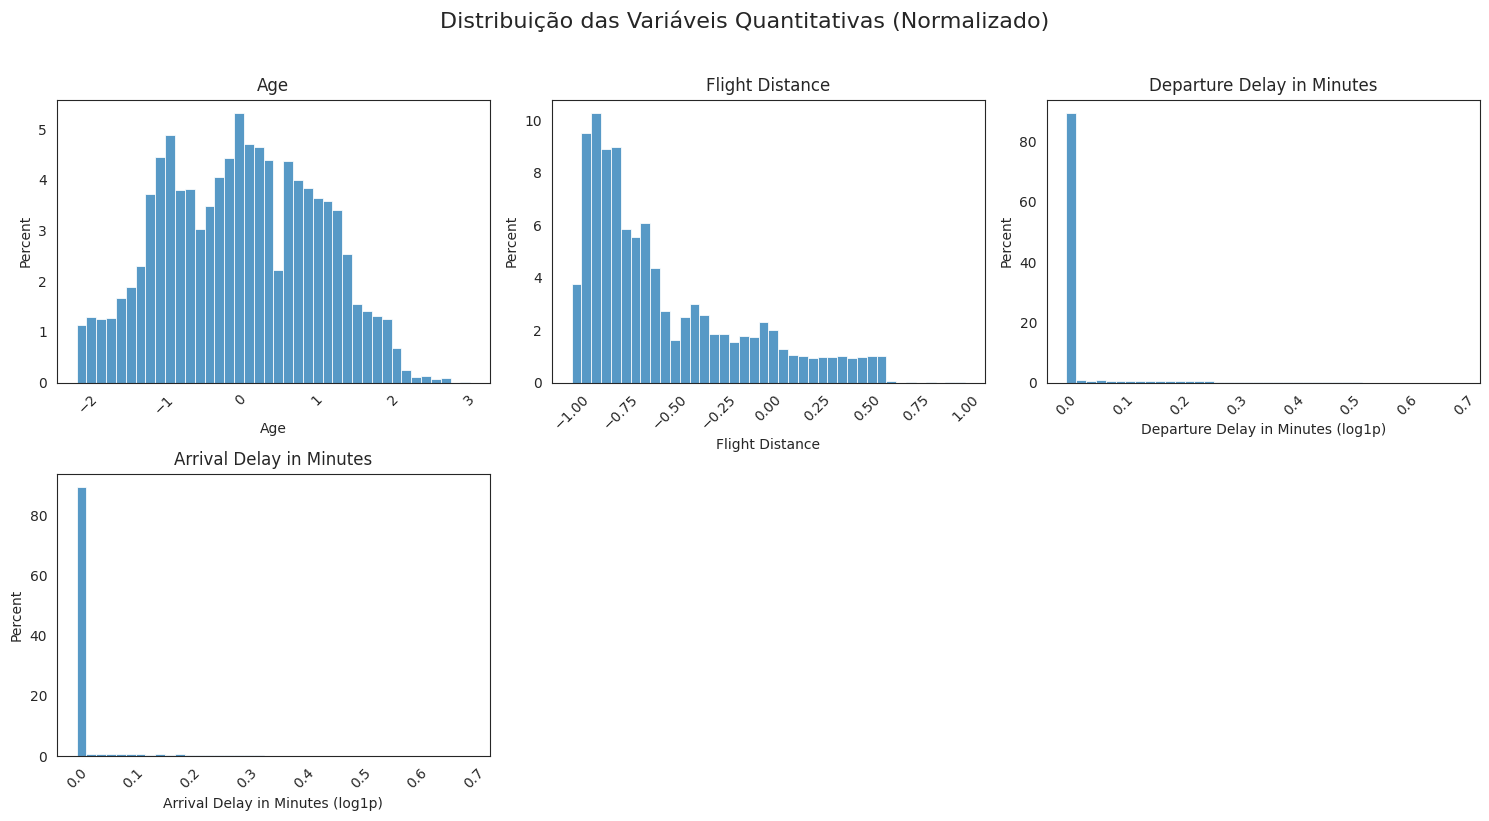

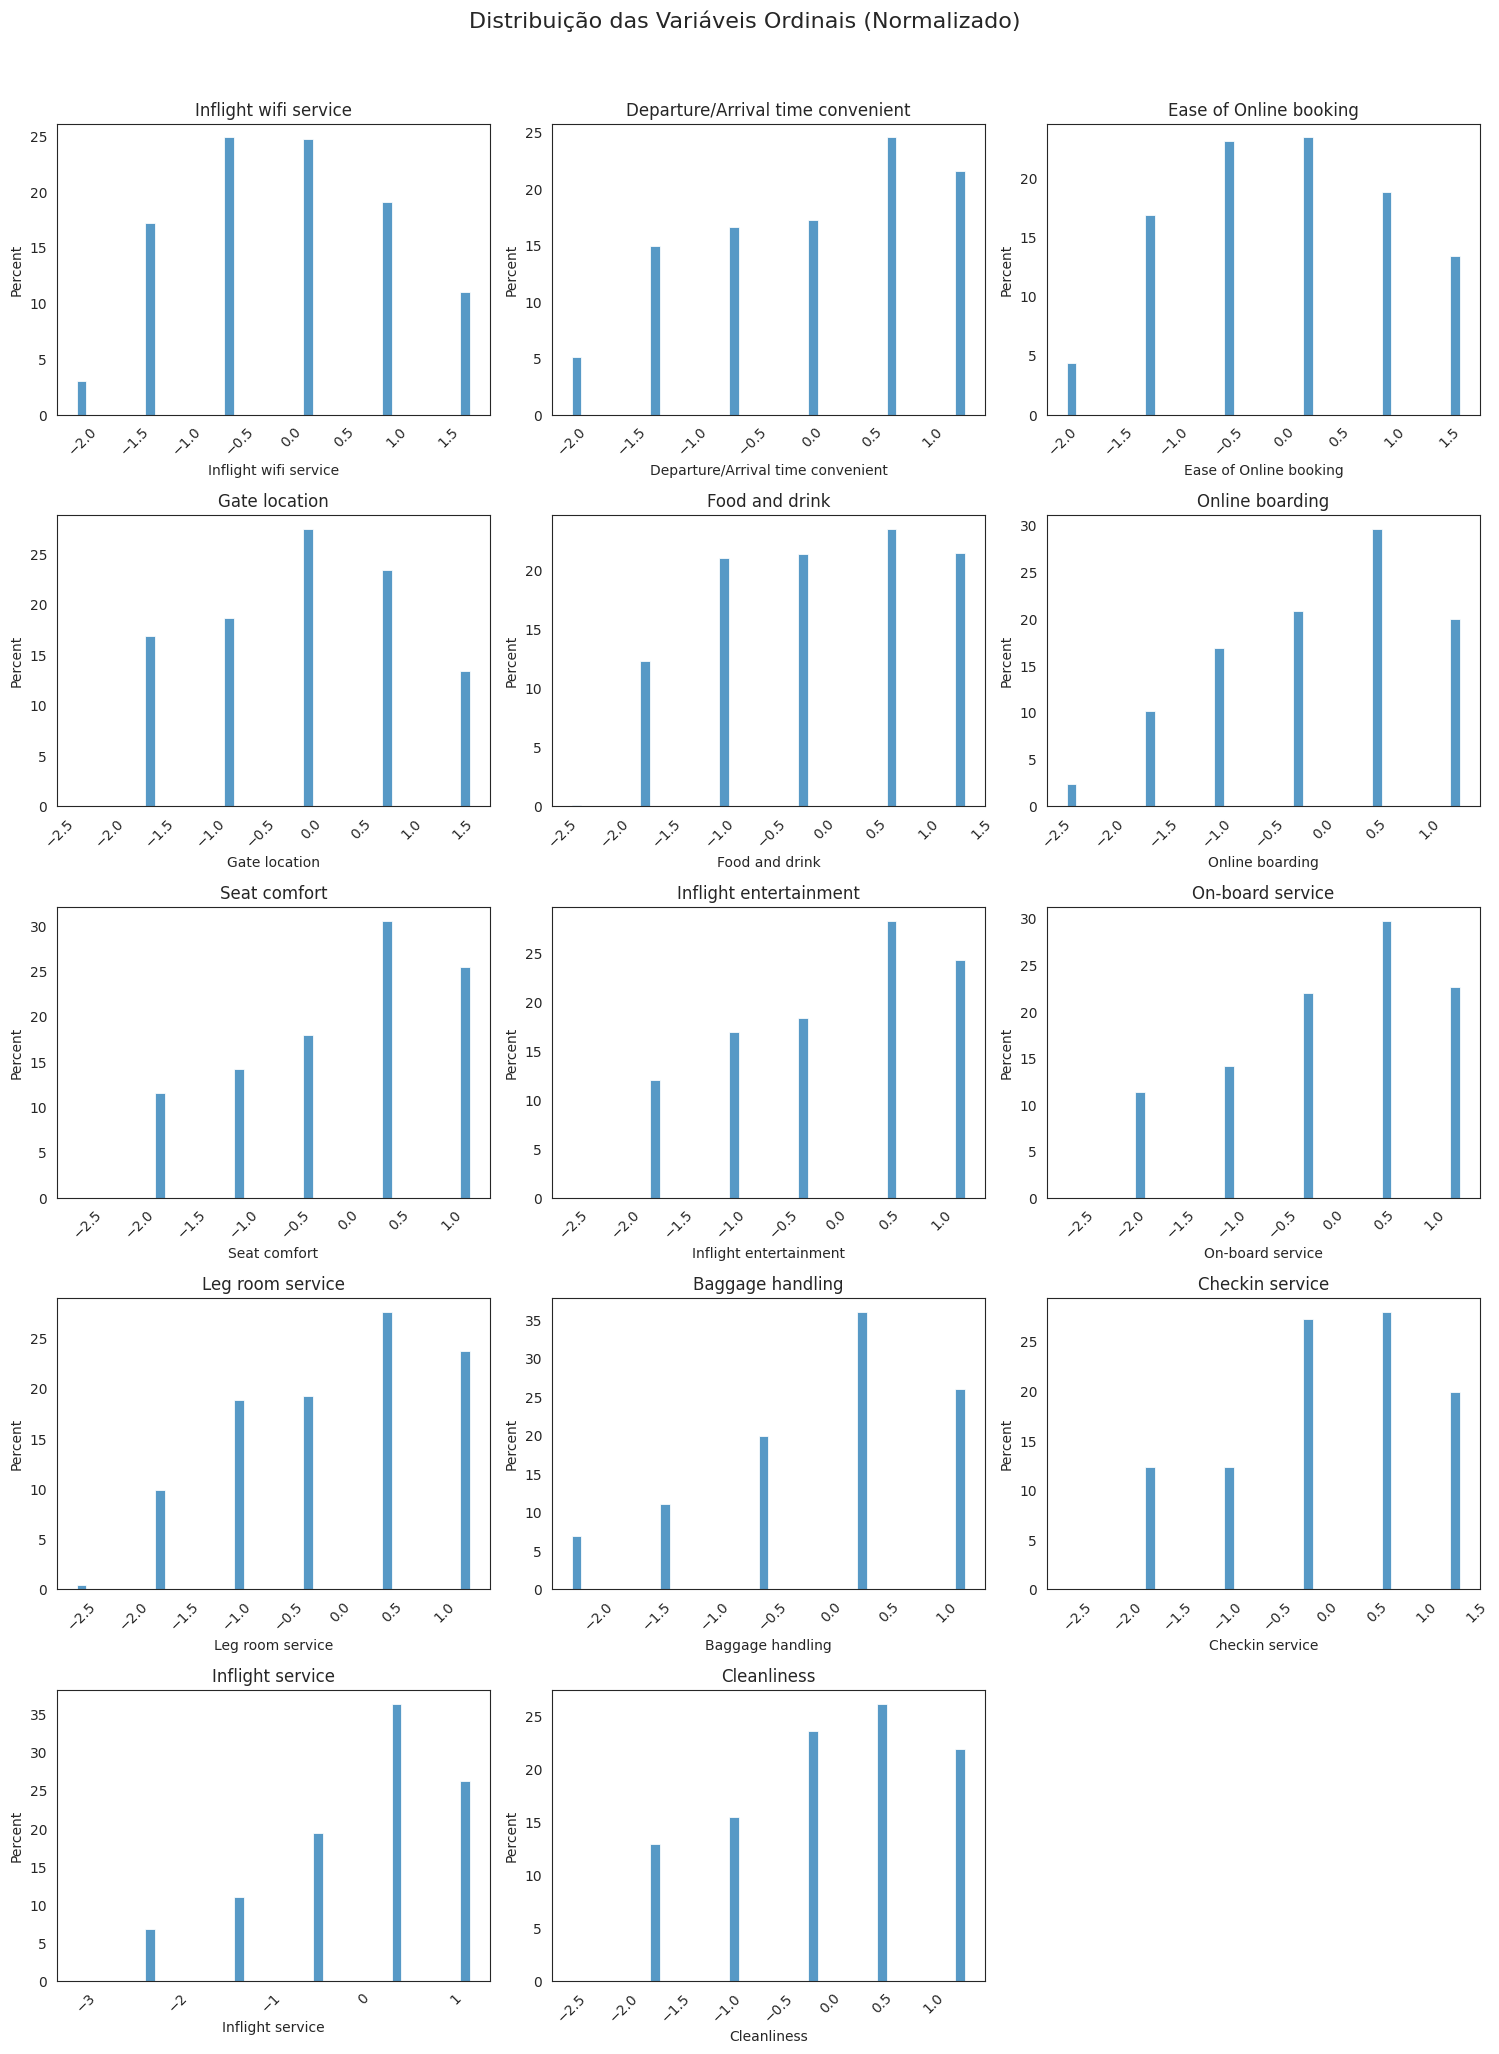

In [7]:
# -------- ONE-HOT + TARGET --------
df_encoded = pd.get_dummies(df, columns=nominal_cols, dtype=int)
df_encoded[target_col] = df_encoded[target_col].map({
    "satisfied": 1,
    "neutral or dissatisfied": 0
})

# -------- NORMALIZAÇÃO --------
df_norm = df_encoded.copy()

# Age + ordinais -> Z-score
scaler_z = StandardScaler()
df_norm[["Age"] + ordinal_cols] = scaler_z.fit_transform(df_norm[["Age"] + ordinal_cols])

# Flight Distance -> MinMax [-1,1]
scaler_fd = MinMaxScaler(feature_range=(-1,1))
df_norm["Flight Distance"] = scaler_fd.fit_transform(df_norm[["Flight Distance"]])

# Delays -> log + MinMax [-1,1]
for col in ["Departure Delay in Minutes", "Arrival Delay in Minutes"]:
    df_norm[col] = np.log1p(df_norm[col].clip(lower=0))
    scaler_delay = MinMaxScaler(feature_range=(-1,1))
    df_norm[col] = scaler_delay.fit_transform(df_norm[[col]])

df_norm.head()
# -------- PLOT NORMALIZADO --------
plot_distributions(
    df_norm,
    quantitative_cols,
    ordinal_cols,
    [],  # <- passa lista vazia, não plota nominais
    title_suffix="(Normalizado)",
    force_ordinal_continuous=True
)


# 4. Implementação MLP

### EXPLICAR

# 5. Treinando Modelo

### EXPLICAR

# 6. Estratégia de treino e teste

In [8]:
drop_cols = ["Unnamed: 0", "id", "satisfaction"]

df_train = df_norm[df_norm["_source"] == "train"].drop(columns=["_source"], errors="ignore")
df_test  = df_norm[df_norm["_source"] == "test"].drop(columns=["_source"], errors="ignore")

X_train = df_train.drop(columns=drop_cols, errors="ignore").apply(pd.to_numeric, errors="coerce").fillna(0).values.astype(float)
y_train = df_train["satisfaction"].astype(int).values

X_test = df_test.drop(columns=drop_cols, errors="ignore").apply(pd.to_numeric, errors="coerce").fillna(0).values.astype(float)
y_test = df_test["satisfaction"].astype(int).values if "satisfaction" in df_test.columns else None

model = mlp(
    n_features=X_train.shape[1],
    n_hidden_layers=2,
    n_neurons_per_layer=[32, 16, 1],
    activation="relu",
    loss="mse",
    optimizer="gd",
    epochs=100,
    eta=0.01
)

model.train(X_train, y_train)



=== Inicialização de Pesos e Biases ===
Camada 1:
W1 shape (32, 27):
[[ 1.72654126e-02  1.11200452e-01  4.68487876e-02 -4.79673840e-04
  -2.55204537e-02  1.97932662e-01  7.80980172e-02  6.24285722e-02
   9.01592908e-02 -1.76884820e-02  8.62882682e-02  3.50209538e-02
  -1.26036969e-01  5.66224335e-02 -1.54613898e-01 -2.14827087e-02
  -1.64081317e-01 -1.56345531e-02  6.49167226e-02 -1.91954846e-01
  -5.98684566e-02  7.26231470e-02 -1.49724709e-02  6.69856515e-02
  -7.71215928e-02  1.00616463e-01  6.46852877e-02]
 [ 2.20642070e-01  1.41315891e-01 -1.36065165e-01 -7.09656867e-02
   8.55318549e-02  2.18560653e-02 -1.61819941e-02  2.40803787e-01
   8.94632731e-02 -1.46322402e-01 -2.39854044e-02  2.43961043e-02
   6.78294427e-02  8.19279180e-02  6.27698699e-02  9.70217444e-02
  -1.11056423e-01  2.42791788e-01  9.54358786e-02 -2.62282075e-02
  -1.43172294e-01 -4.80104675e-02  3.21133102e-02 -9.68466526e-02
   4.96914536e-02  7.43060039e-02 -4.32822059e-02]
 [-6.41661005e-02 -1.23931335e-02 -4

In [9]:
preds_test = model.test(X_test)

# 7. Curva de erro e visualização

Accuracy: 96.11%

=== Pesos e Biases do Modelo ===

Camada 1:
  Pesos W1 (shape (32, 27)):
[[ 6.07810069e-02 -5.32125468e-01  1.13378981e+00 -1.18086418e-02
   2.35701285e-01 -1.85564730e-01  2.22921433e-02 -2.80014094e-01
  -6.55135435e-02 -4.90766949e-02  2.49865807e-01  7.71889157e-02
  -9.85242515e-01  4.27326335e-02 -3.92752756e-01 -2.18696459e-01
  -8.01328138e-02 -3.36767893e-01 -4.79640249e-01 -3.46796637e-01
  -1.04298110e-01 -5.82345961e-01 -1.56721953e-01 -4.90663629e-01
  -3.55635687e-01 -2.69187911e-01  1.36049945e-02]
 [ 3.07187153e-01  1.10827781e-01 -9.58569040e-01  8.70281068e-02
  -1.25748813e-01 -6.05904299e-02  1.05633241e-01  1.45611930e+00
  -9.35161240e-01  3.16169819e-01  1.82172777e-01  2.42275682e-01
  -3.93596752e-01  1.18251013e-01  6.04943577e-01  2.28008038e-01
   3.35703552e-01 -2.90850090e-01 -9.86951160e-02 -3.72271380e-01
   5.10525688e-01 -1.24188262e+00  7.83545260e-01 -1.38845277e+00
   2.79829555e-01 -3.97724156e-01 -3.41564315e-01]
 [-1.97029887e-

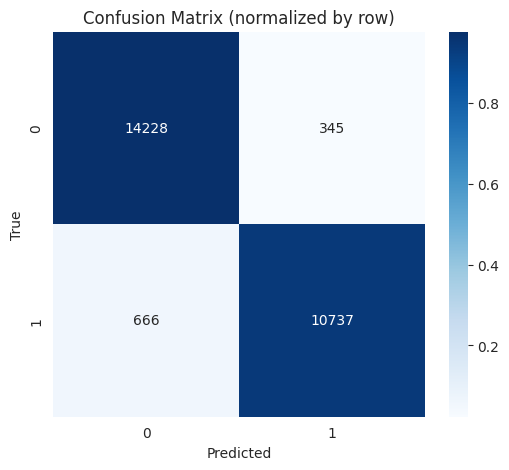

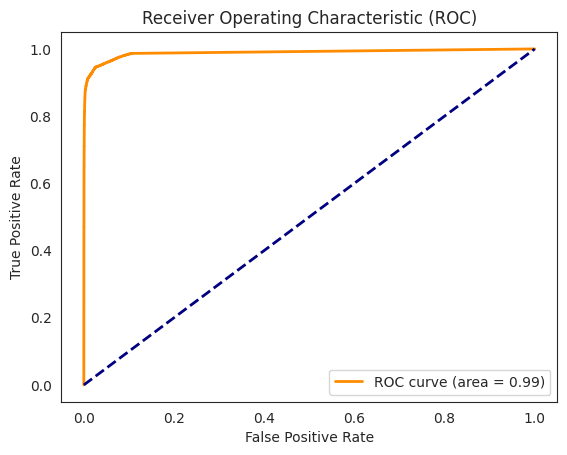

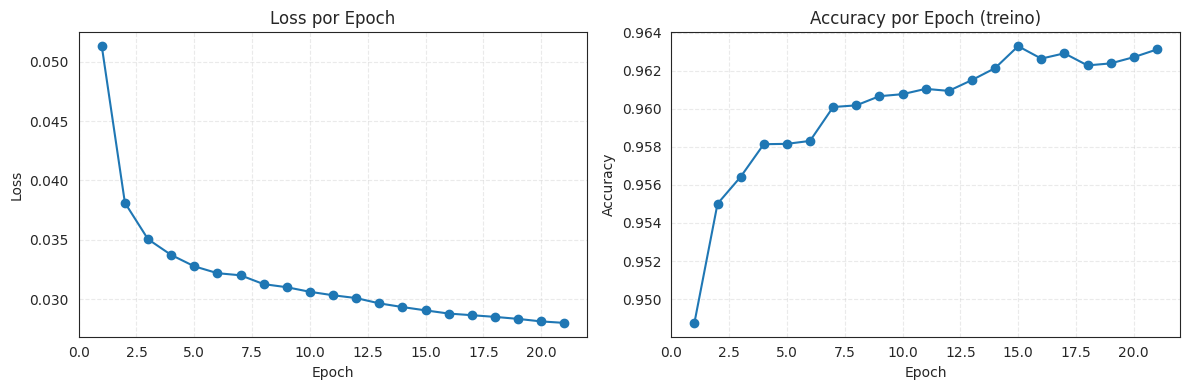

In [10]:
model.evaluate(X_test, y_test, plot_confusion=True, plot_roc=True, preds=preds_test)

# 8. Avaliação do modelo

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

logreg = LogisticRegression(max_iter=500)
logreg.fit(X_train, y_train)
preds = logreg.predict(X_test)

print("Accuracy (LogReg):", accuracy_score(y_test, preds))
print("AUC:", roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1]))


Accuracy (LogReg): 0.8717277486910995
AUC: 0.9269720121120558


In [12]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
preds = rf.predict(X_test)

print("Accuracy (RandomForest):", accuracy_score(y_test, preds))


Accuracy (RandomForest): 0.963658761934093


In [13]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
print("Accuracy (Dummy):", dummy.score(X_test, y_test))


Accuracy (Dummy): 0.5610178626424391
